In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [1]:
!kaggle datasets download -d saurabhshahane/cyberbullying-dataset

Dataset URL: https://www.kaggle.com/datasets/saurabhshahane/cyberbullying-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 82% 53.0M/64.9M [00:00<00:00, 108MB/s]
100% 64.9M/64.9M [00:00<00:00, 108MB/s]


In [2]:
!unzip -q cyberbullying-dataset.zip

In [1]:
!pip install nltk torch torchtext scikit-learn

import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import torch
from torch.utils.data import DataLoader, Dataset
from collections import Counter
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')




  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    else:
        return ""

def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(lemmatized_tokens)

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

In [5]:
racism_df = pd.read_csv('twitter_racism_parsed_dataset.csv')
aggression_df = pd.read_csv('aggression_parsed_dataset.csv')
attack_df = pd.read_csv('attack_parsed_dataset.csv')
kaggle_df = pd.read_csv('kaggle_parsed_dataset.csv')
toxicity_df = pd.read_csv('toxicity_parsed_dataset.csv')
sexism_df = pd.read_csv('twitter_sexism_parsed_dataset.csv')
twitter_df = pd.read_csv('twitter_parsed_dataset.csv')
youtube_df = pd.read_csv('youtube_parsed_dataset.csv')

racism_df = racism_df.dropna(subset=['oh_label'])
aggression_df = aggression_df.dropna(subset=['oh_label'])
attack_df = attack_df.dropna(subset=['oh_label'])
kaggle_df = kaggle_df.dropna(subset=['oh_label'])
toxicity_df = toxicity_df.dropna(subset=['oh_label'])
sexism_df = sexism_df.dropna(subset=['oh_label'])
twitter_df = twitter_df.dropna(subset=['oh_label'])
youtube_df = youtube_df.dropna(subset=['oh_label'])

racism_df['Text'] = racism_df['Text'].apply(lambda x: tokenize_and_lemmatize(clean_text(x)))
aggression_df['Text'] = aggression_df['Text'].apply(lambda x: tokenize_and_lemmatize(clean_text(x)))
attack_df['Text'] = attack_df['Text'].apply(lambda x: tokenize_and_lemmatize(clean_text(x)))
kaggle_df['Text'] = kaggle_df['Text'].apply(lambda x: tokenize_and_lemmatize(clean_text(x)))
toxicity_df['Text'] = toxicity_df['Text'].apply(lambda x: tokenize_and_lemmatize(clean_text(x)))
sexism_df['Text'] = sexism_df['Text'].apply(lambda x: tokenize_and_lemmatize(clean_text(x)))
twitter_df['Text'] = twitter_df['Text'].apply(lambda x: tokenize_and_lemmatize(clean_text(x)))
youtube_df['Text'] = youtube_df['Text'].apply(lambda x: tokenize_and_lemmatize(clean_text(x)))

racism_df = racism_df[['Text', 'oh_label']]
aggression_df = aggression_df[['Text', 'oh_label']]
attack_df = attack_df[['Text', 'oh_label']]
kaggle_df = kaggle_df[['Text', 'oh_label']]
toxicity_df = toxicity_df[['Text', 'oh_label']]
sexism_df = sexism_df[['Text', 'oh_label']]
twitter_df = twitter_df[['Text', 'oh_label']]
youtube_df = youtube_df[['Text', 'oh_label']]

combined_df = pd.concat([racism_df, aggression_df, attack_df, kaggle_df, toxicity_df, sexism_df, twitter_df, youtube_df])
combined_df.to_csv('combined_cyberbullying_dataset.csv', index=False)
combined_df = combined_df.sample(frac=1).reset_index(drop=True)
train_df, test_df = train_test_split(combined_df, test_size=0.2, random_state=42)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['Text'])
y_train = train_df['oh_label']
X_test = vectorizer.transform(test_df['Text'])
y_test = test_df['oh_label']


In [7]:
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    return accuracy, precision, recall, f1

models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear')
}

results = {}

for model_name, model in models.items():
    accuracy, precision, recall, f1 = train_evaluate_model(model, X_train, y_train, X_test, y_test)
    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  Accuracy: {metrics['Accuracy']:.4f}")
    print(f"  Precision: {metrics['Precision']:.4f}")
    print(f"  Recall: {metrics['Recall']:.4f}")
    print(f"  F1 Score: {metrics['F1 Score']:.4f}\n")



Naive Bayes:
  Accuracy: 0.9192
  Precision: 0.8033
  Recall: 0.4795
  F1 Score: 0.6005

Logistic Regression:
  Accuracy: 0.9296
  Precision: 0.8131
  Recall: 0.5770
  F1 Score: 0.6750

SVM:
  Accuracy: 0.9303
  Precision: 0.8205
  Recall: 0.5757
  F1 Score: 0.6766



In [8]:
import joblib

joblib.dump(models["Naive Bayes"], 'naive_bayes_model.joblib')
joblib.dump(models["Logistic Regression"], 'logistic_regression_model.joblib')
joblib.dump(models["SVM"], 'svm_model.joblib')
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

In [24]:
def load_models_and_vectorizer():
    naive_bayes_model = joblib.load('naive_bayes_model.joblib')
    logistic_regression_model = joblib.load('logistic_regression_model.joblib')
    svm_model = joblib.load('svm_model.joblib')
    vectorizer = joblib.load('tfidf_vectorizer.joblib')
    return naive_bayes_model, logistic_regression_model, svm_model, vectorizer

def predict_cyberbullying(text, model_name):
    naive_bayes_model, logistic_regression_model, svm_model, vectorizer = load_models_and_vectorizer()
    models = {
        "Naive Bayes": naive_bayes_model,
        "Logistic Regression": logistic_regression_model,
        "SVM": svm_model
    }

    model = models.get(model_name)
    if not model:
        raise ValueError(f"Model '{model_name}' not found. Available models are: {list(models.keys())}")

    text_cleaned = tokenize_and_lemmatize(clean_text(text))
    text_vectorized = vectorizer.transform([text_cleaned])
    prediction = model.predict(text_vectorized)

    return "Cyberbullying" if prediction[0] == 1 else "Not Cyberbullying"

text = "You are loser you know it haha"
model_name = "Naive Bayes"
prediction = predict_cyberbullying(text, model_name)
print(f"Prediction using {model_name}: {prediction}")


Prediction using Naive Bayes: Cyberbullying


In [9]:
# Initialize Count Vectorizer and fit data
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(max_features=5000)
X = count_vectorizer.fit_transform(combined_df['Text'])

# Get word frequencies
word_freq = X.sum(axis=0).A1
words = count_vectorizer.get_feature_names_out()
word_freq_df = pd.DataFrame(list(zip(words, word_freq)), columns=['Word', 'Frequency'])

# Get top 25 most frequent words
top_25_freq = word_freq_df.nlargest(25, 'Frequency')

# Get top 25 least frequent words
top_25_infreq = word_freq_df.nsmallest(25, 'Frequency')

<ipython-input-29-409eef326fd7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=top_25_freq, palette='viridis')


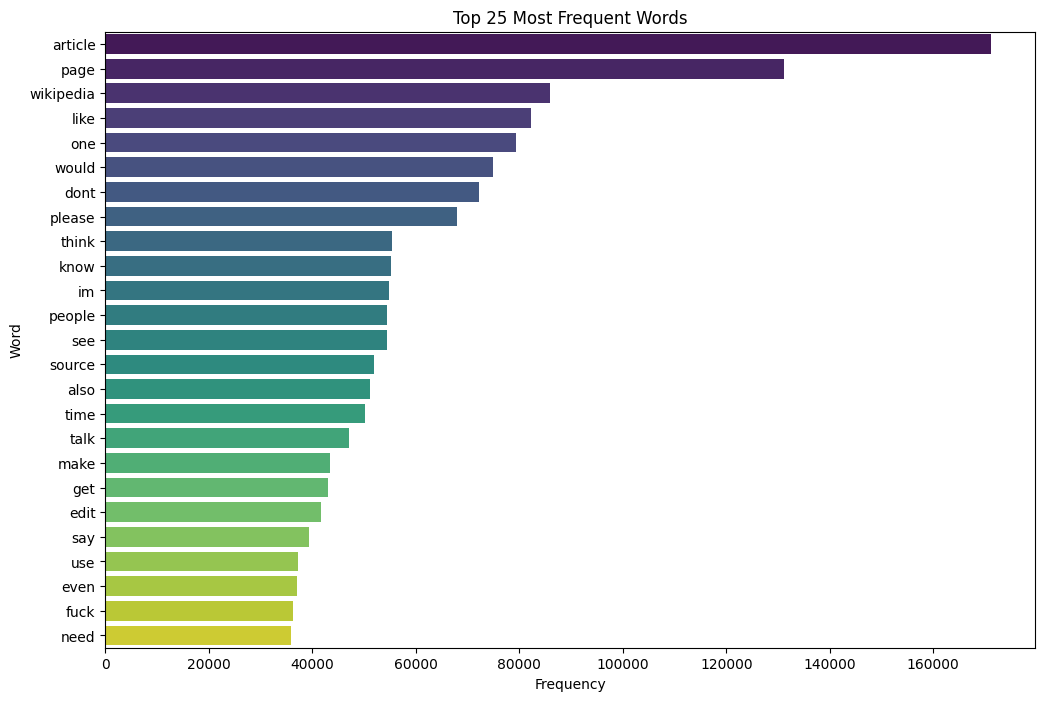

<ipython-input-29-409eef326fd7>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=top_25_infreq, palette='viridis')


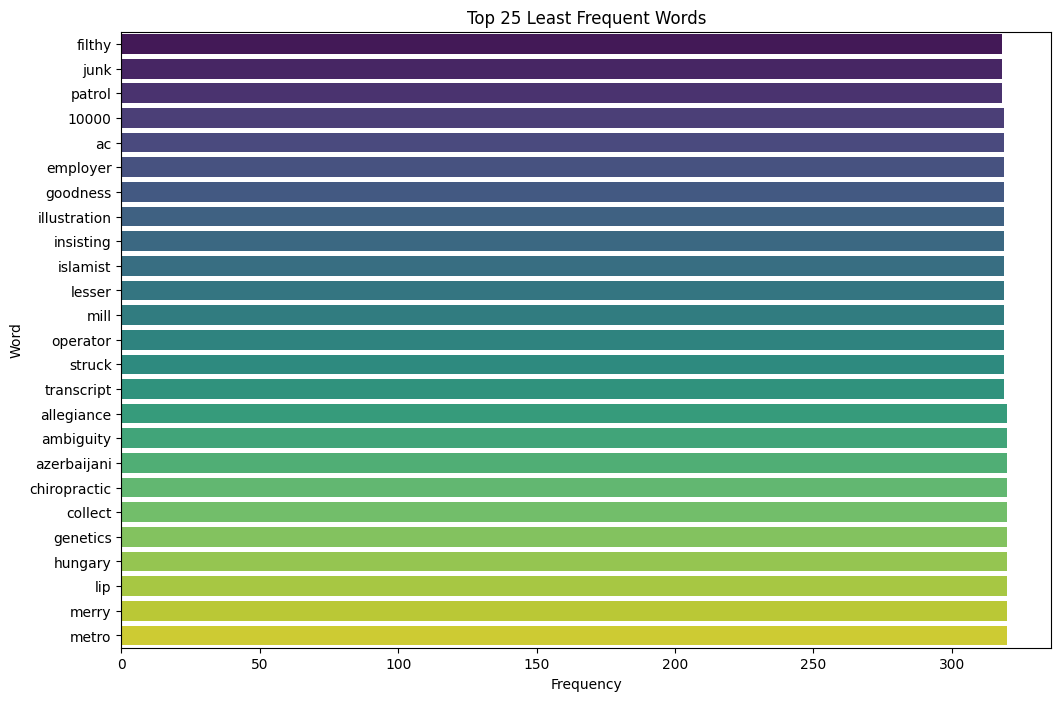

In [ ]:
# Plot top 25 most frequent words
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Word', data=top_25_freq, palette='viridis')
plt.title('Top 25 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

# Plot top 25 least frequent words
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Word', data=top_25_infreq, palette='viridis')
plt.title('Top 25 Least Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


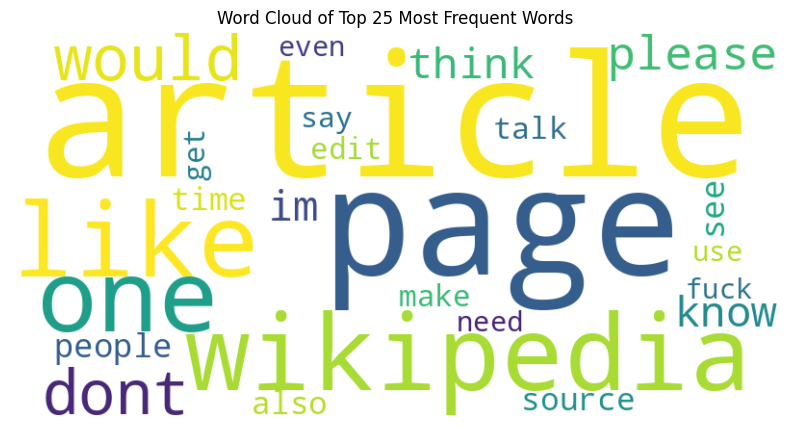

In [30]:
from wordcloud import WordCloud

# Generate word cloud for most frequent words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(top_25_freq['Word'], top_25_freq['Frequency'])))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Top 25 Most Frequent Words')
plt.show()


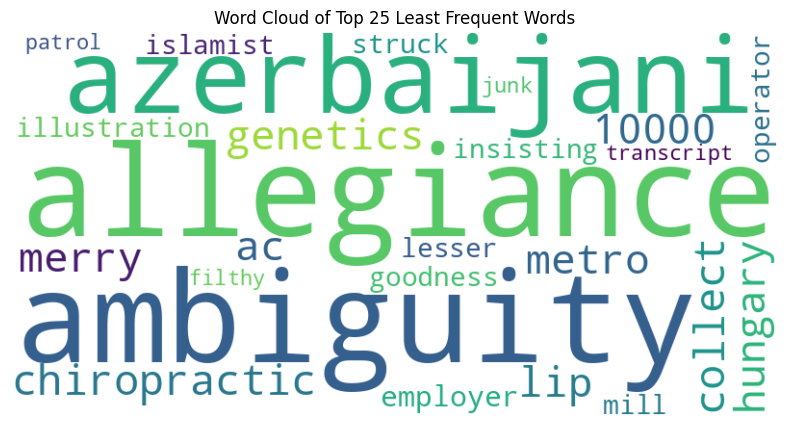

In [31]:
# Generate word cloud for least frequent words
wordcloud_infreq = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(top_25_infreq['Word'], top_25_infreq['Frequency'])))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_infreq, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Top 25 Least Frequent Words')
plt.show()


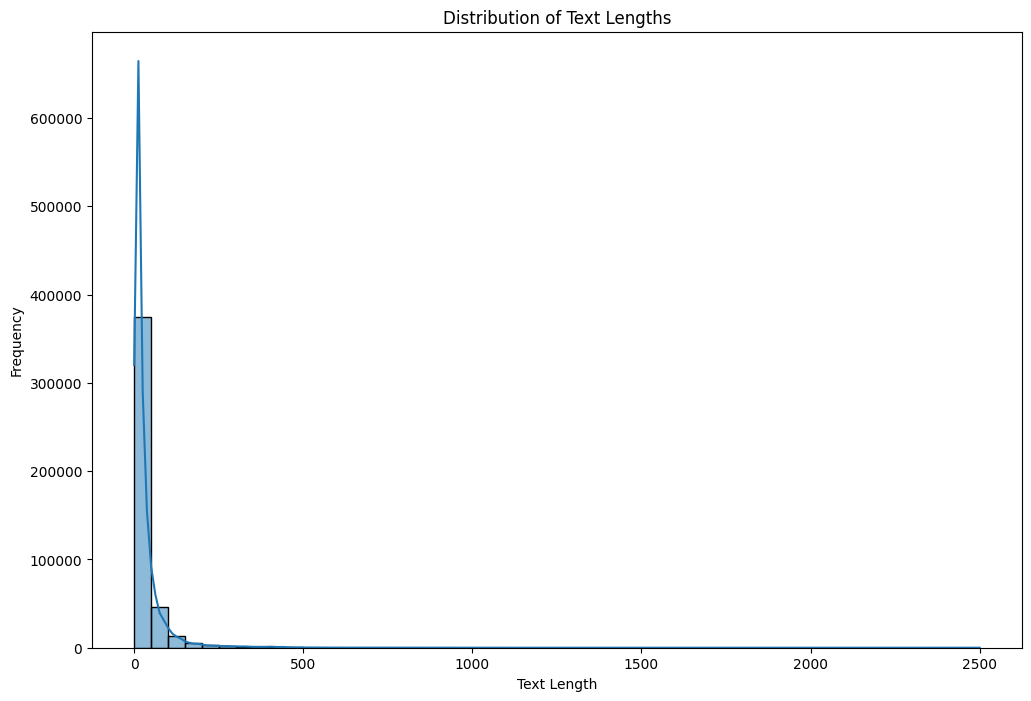

In [32]:
# Calculate text lengths
combined_df['Text Length'] = combined_df['Text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 8))
sns.histplot(combined_df['Text Length'], bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


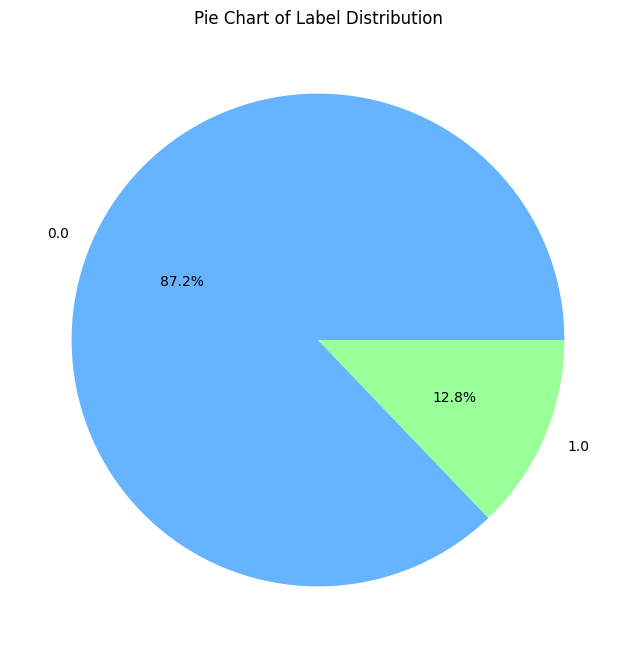

In [36]:
plt.figure(figsize=(8, 8))
combined_df['oh_label'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#66b3ff', '#99ff99'])
plt.title('Pie Chart of Label Distribution')
plt.ylabel('')
plt.show()


<ipython-input-37-282762efed85>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=top_10_cyberbullying, palette='viridis')


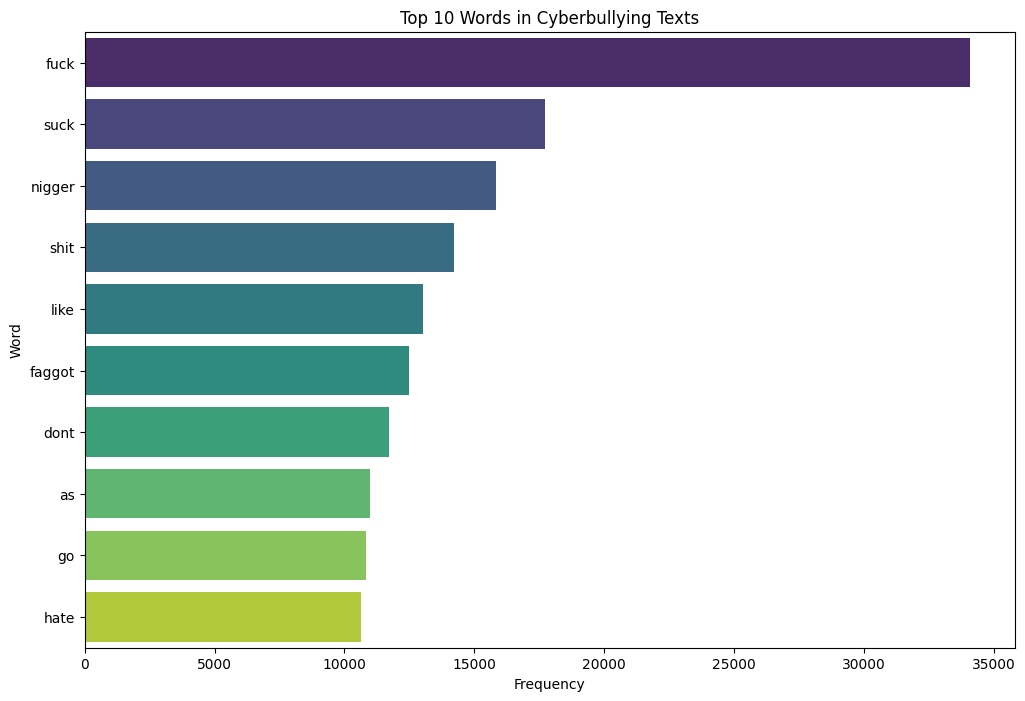

In [37]:
# Filter texts labeled as cyberbullying
cyberbullying_texts = combined_df[combined_df['oh_label'] == 1]['Text']

# Vectorize and get word frequencies
cyberbullying_vectorizer = CountVectorizer(max_features=1000)
X_cyberbullying = cyberbullying_vectorizer.fit_transform(cyberbullying_texts)
word_freq_cyberbullying = X_cyberbullying.sum(axis=0).A1
words_cyberbullying = cyberbullying_vectorizer.get_feature_names_out()
word_freq_df_cyberbullying = pd.DataFrame(list(zip(words_cyberbullying, word_freq_cyberbullying)), columns=['Word', 'Frequency'])

# Get top 10 words
top_10_cyberbullying = word_freq_df_cyberbullying.nlargest(10, 'Frequency')

plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Word', data=top_10_cyberbullying, palette='viridis')
plt.title('Top 10 Words in Cyberbullying Texts')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


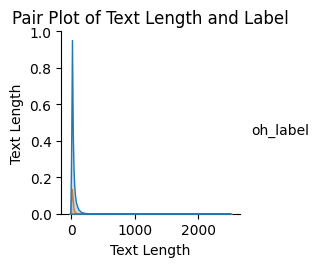

In [38]:
sns.pairplot(combined_df, hue='oh_label', vars=['Text Length'])
plt.title('Pair Plot of Text Length and Label')
plt.show()


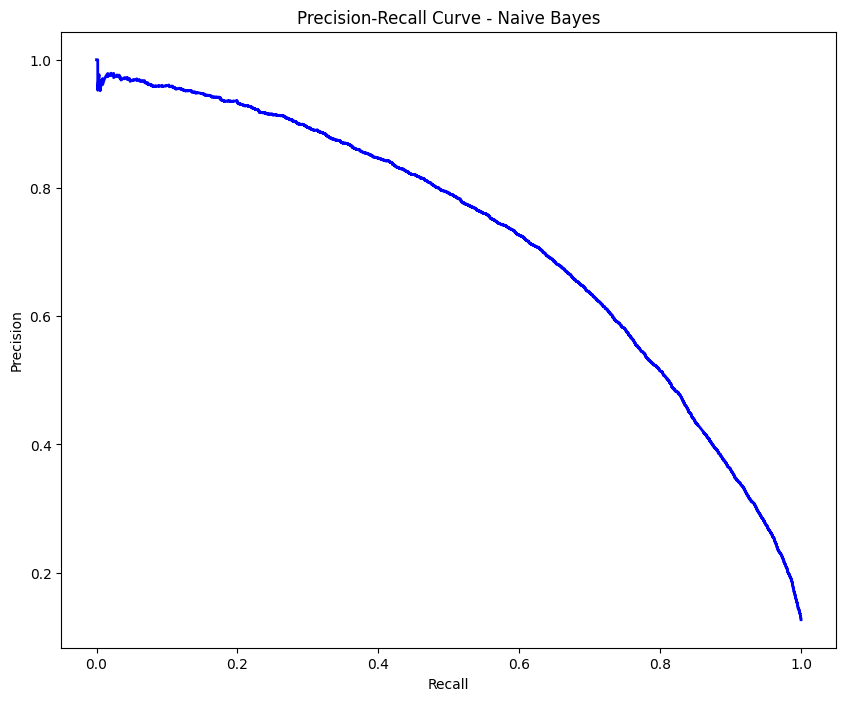

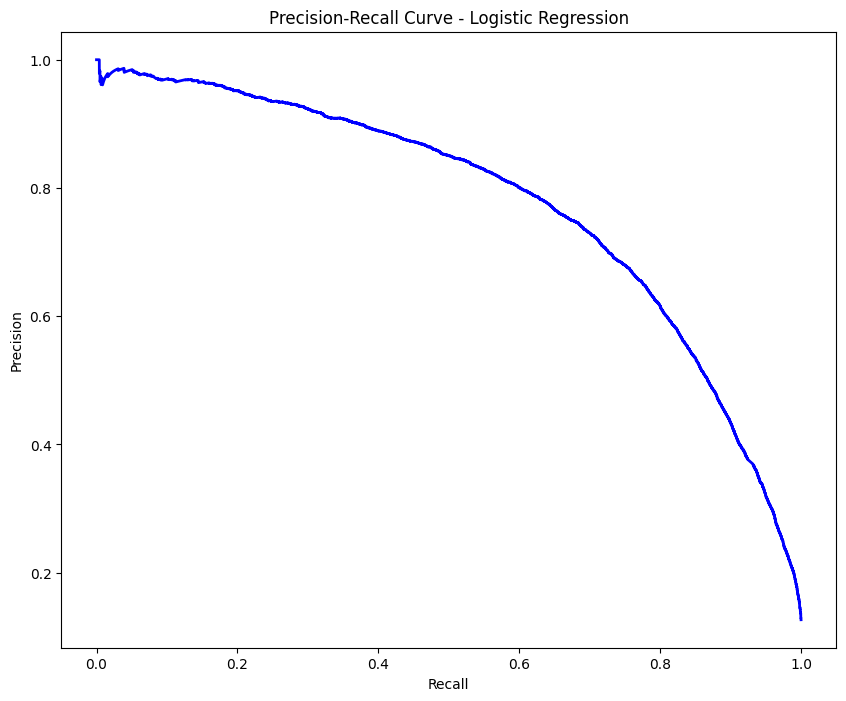

In [39]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(model, X_test, y_test, model_name):
    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)

    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision, color='b', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.show()

# Example usage
for model_name, model in models.items():
    if hasattr(model, "predict_proba"):
        plot_precision_recall_curve(model, X_test, y_test, model_name)


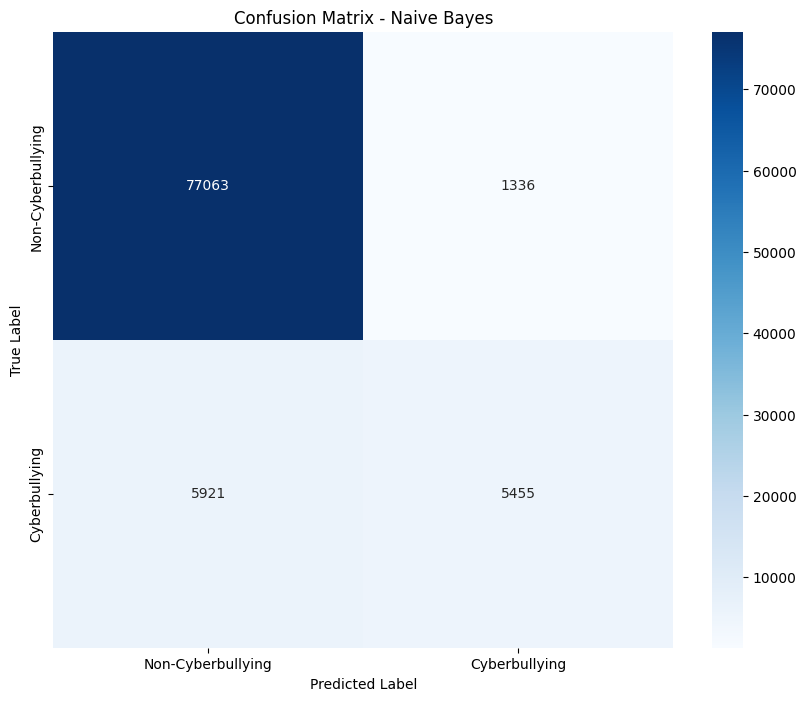

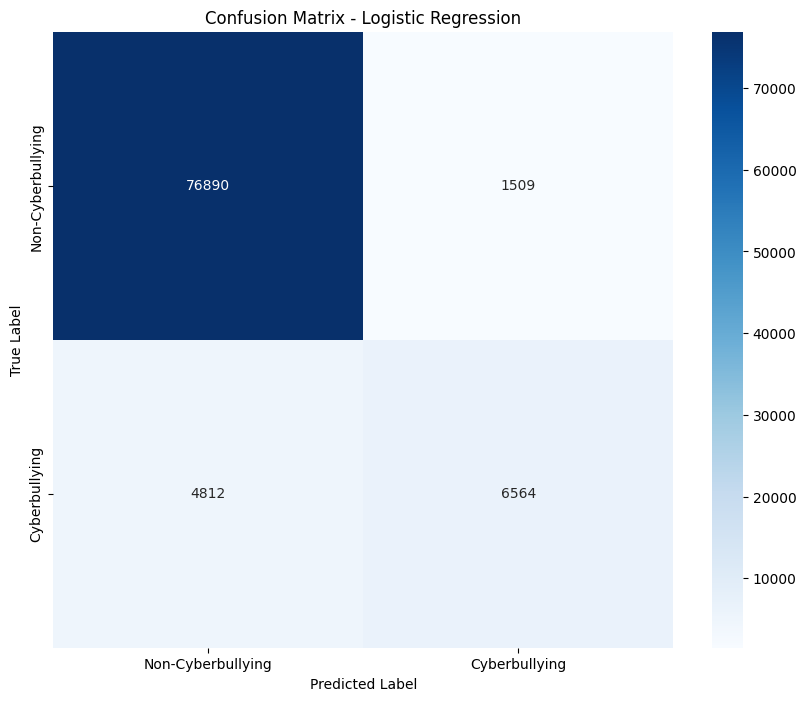

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Cyberbullying', 'Cyberbullying'], yticklabels=['Non-Cyberbullying', 'Cyberbullying'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Example usage
for model_name, model in models.items():
    plot_confusion_matrix(model, X_test, y_test, model_name)
